# DAS Temperature Test

Can we see slow temperature changes in the DAS data.

In [1]:
# load modules
import glob
import numpy as np
import matplotlib.pyplot as plt
import h5py
import datetime
import scipy
import os
import pandas as pd

In [2]:
# helper functions
def sintela_to_datetime(sintela_times):
    '''returns an array of datetime.datetime ''' 
    days1970 = datetime.date(1970, 1, 1).toordinal()
    # Vectorize everything
    converttime = np.vectorize(datetime.datetime.fromordinal)
    addday_lambda = lambda x : datetime.timedelta(days=x)
    adddays = np.vectorize(addday_lambda)
    day = days1970 + sintela_times/1e6/60/60/24
    thisDateTime = converttime(np.floor(day).astype(int))
    dayFraction = day-np.floor(day)
    thisDateTime = thisDateTime + adddays(dayFraction)
    return thisDateTime

In [883]:
# get all hdf5 file names from given directory
files = glob.glob('../../../data/lab/Onyx_temp_test/data_1Hz/*h5')
files.sort()
print('{} files in directory'.format(len(files)))

136 files in directory


In [587]:
for file_idx in range(len(files)):
    print("File {} of {}".format(file_idx+1, len(files)), end="\r")
    try:
        f = h5py.File(files[file_idx],'r')
        data = np.array(f['Acquisition/Raw[0]/RawData'])
        times = sintela_to_datetime(np.array(f['Acquisition/Raw[0]/RawDataTime']))
        if file_idx == 0:
            all_data = data
            all_times = times
        else:
            all_data = np.concatenate([all_data, data])
            all_times = np.concatenate([all_times, times])
        f.close()
    except OSError: # something wrong with the file
        pass
    except ValueError: # something wrong with the data
        pass

In [588]:
all_data.shape, all_times.shape

((8120, 158), (8120,))

In [589]:
nt = all_data.shape[0]
nx = all_data.shape[1]
print('Number of time steps: {}, Number of channels: {}'.format(nt,nx))
print("Sampling Frequency: {} Hz, cable length: {:.1f} m".format(attrs['PulseRate'], attrs['SpatialSamplingInterval']*nx))

Number of time steps: 8120, Number of channels: 158
Sampling Frequency: 1.0 Hz, cable length: 1008.2 m


## Raw Data Waterfall

Let's have a first look into the data! But careful! Some small data gaps might not be visible in the above plot, because of aliasing.

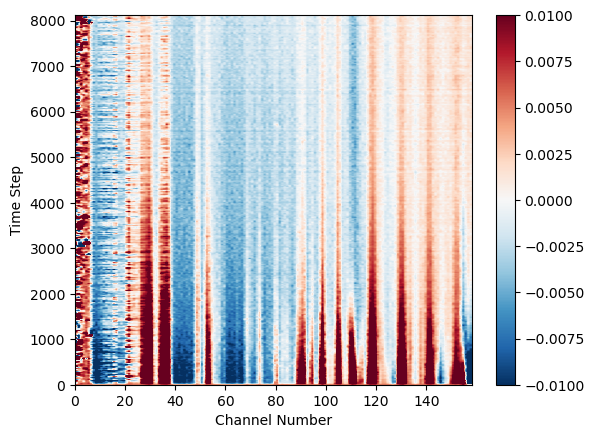

In [590]:
# plot the raw data including data gaps
import matplotlib
cmap = plt.get_cmap('RdBu_r')
cmap.set_bad(color='white')
# normalize each channel by the maximum amplitude
data_norm = all_data.copy()
data_norm -= np.mean(data_norm[~np.isnan(data_norm)], axis=0)
data_norm = data_norm / (np.max(data_norm[~np.isnan(data_norm)], axis=0) - np.min(data_norm[~np.isnan(data_norm)], axis=0))
fig, ax = plt.subplots()
im = ax.imshow(data_norm, aspect='auto', 
               vmin=-0.01,vmax=0.01, 
               extent=[0,nx,0,nt], 
               cmap=cmap, origin='lower',
               # interpolation='none'
              )
cbar = plt.colorbar(im)
plt.xlabel('Channel Number')
plt.ylabel('Time Step')
plt.show()

### Select Data to have a closer look!!!

In [801]:
# select channels to look into (exclude bad channels in which we are not interested)
start_cha = 60#100#125 
end_cha = 67#150#135 #nx
t_start = 60 # in seconds
t_end = nt/attrs['PulseRate'] # in seconds

data_select = all_data[int(t_start*attrs['PulseRate']):int(t_end*attrs['PulseRate'])
                   ,start_cha:end_cha]

## Waterfall Plot

Note that the raw data should be proportional to strain rate (ie. temperature change).

In [802]:
# normalize each channel by the maximum amplitude
data_norm = data_select.copy()
data_norm -= np.mean(data_norm[~np.isnan(data_norm)], axis=0)
data_norm = data_norm / (np.max(data_norm[~np.isnan(data_norm)], axis=0) - np.min(data_norm[~np.isnan(data_norm)], axis=0))

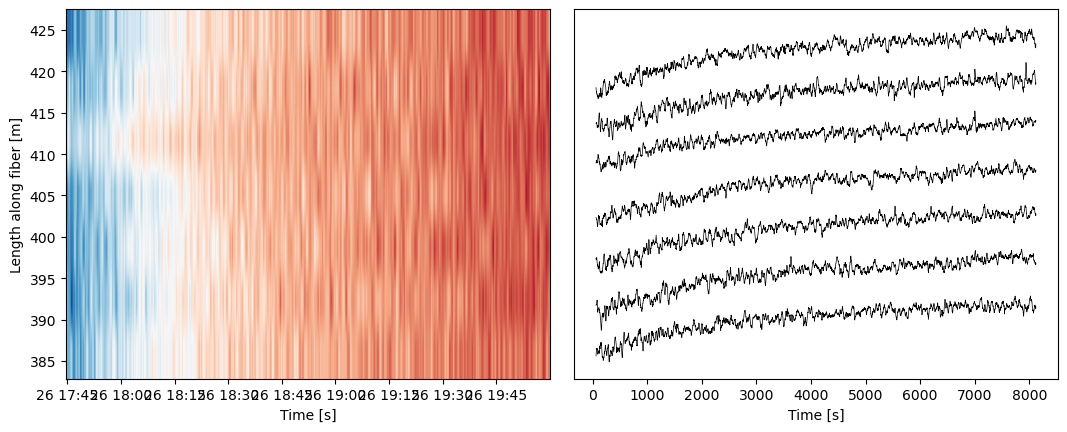

In [803]:
# plot the selected data as image and as traces
fig, ax = plt.subplots(1,2, figsize=(2*6.4,4.8))

# left plot
ax[0].imshow(data_norm.T, origin='lower',
           aspect='auto',
             # vmin=np.percentile(data_norm[~np.isnan(data_norm)],1),
             # vmax=np.percentile(data_norm[~np.isnan(data_norm)],99),
           extent=[all_times[0],all_times[-1],
                   start_cha*attrs['SpatialSamplingInterval'],
                   end_cha*attrs['SpatialSamplingInterval']],
            cmap='RdBu_r',
            # interpolation='none'
            )
# right plot
t_axis = np.arange(t_start, t_end, 1/attrs['PulseRate'])
for i in range(0, np.shape(data_select)[1], 1):
    ax[1].plot(t_axis, start_cha+i+data_norm[:,i]*2, linestyle='-', color='k', alpha=1, linewidth=0.5)
    
ax[0].set_ylabel('Length along fiber [m]')
ax[1].set_yticks([])
ax[0].set_xlabel('Time [s]')
ax[1].set_xlabel('Time [s]')
# ax[1].set_ylim(start_cha-1, np.shape(data_select)[1]+1)
plt.subplots_adjust(wspace=0.05)
plt.show()
# fig.savefig('../../plots/DAS_labtest/temperature_test/fig1.png', dpi=300, bbox_inches='tight')

## Pick a single channel and plot

Text(0.5, 0, 'Time [s]')

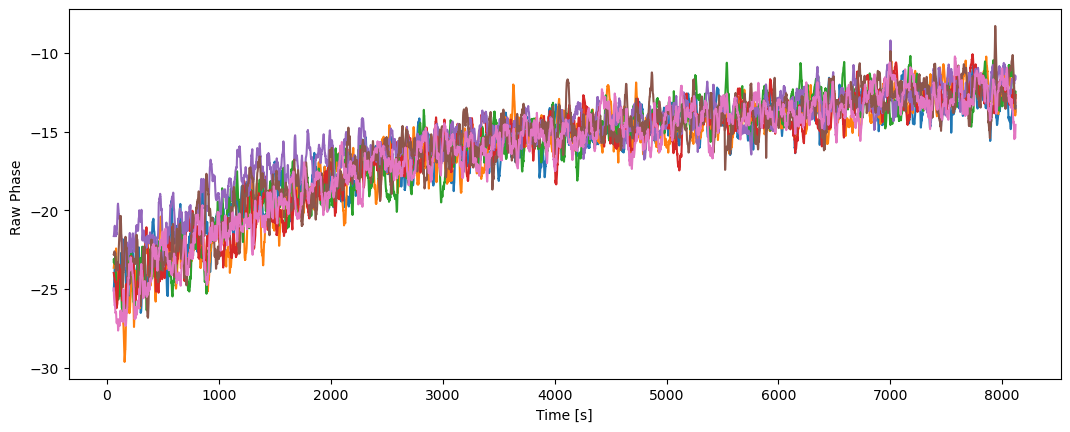

In [804]:
fig, ax = plt.subplots(figsize=(2*6.4,4.8))
t_axis = np.arange(t_start, t_end, 1/attrs['PulseRate'])
# colors = plt.cm.cividis(np.linspace(0,1,np.shape(data_select)[1]))
for i in range(np.shape(data_select)[1]):
    ax.plot(t_axis, data_select[:,i])#, color=colors[i])
ax.set_ylabel('Raw Phase ')
ax.set_xlabel('Time [s]')


## Read DTS data

In [805]:
df_read = pd.read_csv('../../../data/lab/Onyx_temp_test/XT-DTS/Temp_Test_distributed_data_1.csv',
                      index_col=0, header=0, infer_datetime_format=True)
                      
df_read = df_read.iloc[1:,:-2]
df_read = df_read.astype(float)
df_read['Distance'] = df_read.index
df_read['Distance'] = df_read['Distance'].astype(float)
df_read.set_index('Distance', inplace=True)
df_read.columns = pd.to_datetime(df_read.columns, format='%Y/%m/%d %H:%M:%S')
df_read.head()

,2023-05-26 17:04:23,2023-05-26 17:05:24,2023-05-26 17:06:25,2023-05-26 17:07:26,2023-05-26 17:08:27,2023-05-26 17:09:28,2023-05-26 17:10:29,2023-05-26 17:11:30,2023-05-26 17:12:31,2023-05-26 17:13:32,...,2023-05-26 19:47:09,2023-05-26 19:48:10,2023-05-26 19:49:11,2023-05-26 19:50:12,2023-05-26 19:51:13,2023-05-26 19:52:14,2023-05-26 19:53:15,2023-05-26 19:54:16,2023-05-26 19:55:17,2023-05-26 19:56:18
Distance,,,,,,,,,,,,,,,,,,,,,
-0.121,23.928,23.799,24.011,24.166,24.098,24.153,24.291,24.370,24.456,24.478,...,29.670,29.738,29.777,29.794,29.808,29.760,29.792,29.871,29.773,29.787
0.133,23.599,23.356,23.511,23.773,23.598,23.602,23.663,23.690,23.826,23.755,...,26.039,26.060,26.120,26.098,26.161,26.107,26.128,26.173,26.029,26.080
0.388,24.792,24.485,24.513,24.854,24.676,24.700,24.743,24.695,24.894,24.810,...,25.683,25.718,25.791,25.751,25.868,25.780,25.797,25.813,25.565,25.651
0.642,26.048,25.797,25.732,26.042,25.979,26.147,26.161,26.096,26.263,26.292,...,27.434,27.548,27.595,27.632,27.745,27.637,27.685,27.665,27.341,27.488
0.896,25.544,25.392,25.280,25.388,25.455,25.673,25.676,25.626,25.694,25.839,...,27.215,27.354,27.344,27.459,27.583,27.500,27.546,27.448,27.138,27.420


In [806]:
# find where starting/end channels are
start_dist = start_cha * attrs['SpatialSamplingInterval'] -6 # -10 because of DAS patch cable
end_dist = end_cha * attrs['SpatialSamplingInterval'] -6
start_time = all_times[0]
end_time = all_times[-1]

# cut out the relevant dataframe with selected channels and times
df = df_read.copy()
df = df[(df.index>=start_dist) & (df.index<=end_dist)]
df = df.iloc[:,(df.columns>=start_time) & (df.columns<=end_time)]

temp_arr = df.to_numpy()
temp_arr = temp_arr.T

df

,2023-05-26 17:45:04,2023-05-26 17:46:05,2023-05-26 17:47:06,2023-05-26 17:48:07,2023-05-26 17:49:08,2023-05-26 17:50:09,2023-05-26 17:51:10,2023-05-26 17:52:11,2023-05-26 17:53:12,2023-05-26 17:54:13,...,2023-05-26 19:47:09,2023-05-26 19:48:10,2023-05-26 19:49:11,2023-05-26 19:50:12,2023-05-26 19:51:13,2023-05-26 19:52:14,2023-05-26 19:53:15,2023-05-26 19:54:16,2023-05-26 19:55:17,2023-05-26 19:56:18
Distance,,,,,,,,,,,,,,,,,,,,,
377.111,46.385,46.378,46.206,46.002,46.121,45.896,45.687,45.686,45.440,45.403,...,36.496,36.363,36.442,36.404,36.275,36.231,36.114,36.049,36.064,35.997
377.365,46.281,46.233,46.092,45.905,45.978,45.782,45.632,45.596,45.360,45.333,...,36.425,36.303,36.385,36.340,36.235,36.155,36.057,35.972,35.958,35.962
377.619,46.022,45.927,45.856,45.642,45.733,45.529,45.412,45.361,45.199,45.134,...,36.293,36.143,36.246,36.172,36.101,35.994,35.946,35.832,35.814,35.814
377.874,45.452,45.360,45.311,45.088,45.250,45.021,44.917,44.870,44.722,44.672,...,36.074,35.934,36.006,35.931,35.830,35.780,35.729,35.601,35.592,35.570
378.128,45.065,45.035,44.910,44.706,44.930,44.692,44.579,44.544,44.372,44.365,...,35.940,35.862,35.884,35.812,35.694,35.695,35.560,35.467,35.452,35.450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420.325,46.254,46.237,46.057,45.934,46.001,45.830,45.711,45.697,45.547,45.513,...,36.861,36.726,36.703,36.618,36.641,36.503,36.444,36.361,36.391,36.236
420.579,46.698,46.655,46.504,46.369,46.440,46.243,46.118,46.156,45.944,45.918,...,37.336,37.227,37.200,37.133,37.118,37.007,36.951,36.914,36.841,36.751
420.833,47.060,47.015,46.874,46.749,46.839,46.621,46.524,46.546,46.364,46.301,...,37.926,37.827,37.834,37.763,37.679,37.629,37.586,37.525,37.406,37.391


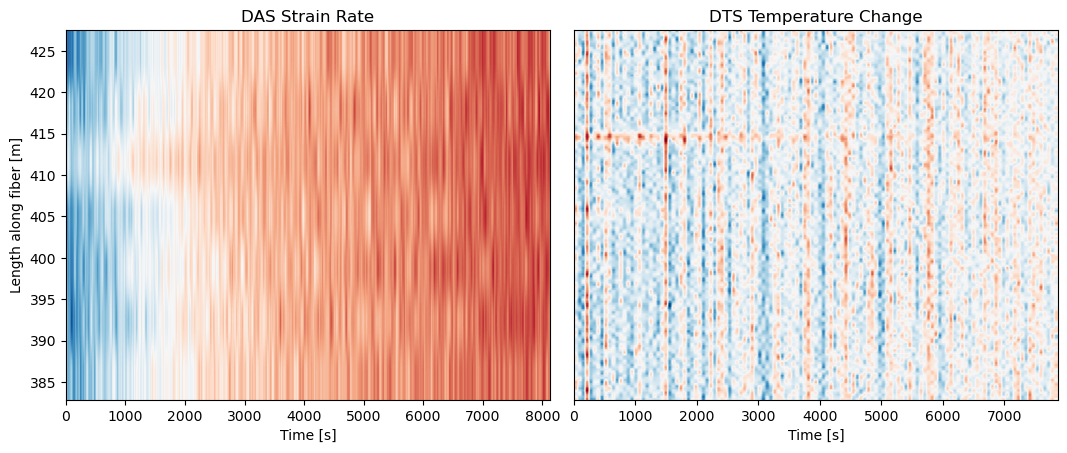

In [807]:
# plot the selected DAS and DTS data
fig, ax = plt.subplots(1,2, figsize=(2*6.4,4.8))

# left plot (DAS measurement)
ax[0].imshow(data_select.T, origin='lower',
           aspect='auto',
             # vmin=np.percentile(data_norm[~np.isnan(data_norm)],1),
             # vmax=np.percentile(data_norm[~np.isnan(data_norm)],99),
           extent=[0, (all_times[-1]-all_times[0]).total_seconds(),
                   start_cha*attrs['SpatialSamplingInterval'],
                   end_cha*attrs['SpatialSamplingInterval']],
            cmap='RdBu_r',
            )
# right plot (DTS measurement)
ax[1].imshow(np.diff(temp_arr.T, axis=1), origin='lower',
           aspect='auto',
            extent=[0,(df.columns[-1]-df.columns[0]).total_seconds(),
                   df.index[0], df.index[-1]],
            cmap='RdBu_r',
            )
ax[0].set_title('DAS Strain Rate')
ax[1].set_title('DTS Temperature Change')
ax[0].set_ylabel('Length along fiber [m]')
ax[1].set_yticks([])
ax[0].set_xlabel('Time [s]')
ax[1].set_xlabel('Time [s]')

plt.subplots_adjust(wspace=0.05)
plt.show()
fig.savefig('../../plots/DAS_labtest/temperature_test/fig2_tempchange.png', dpi=300, bbox_inches='tight')

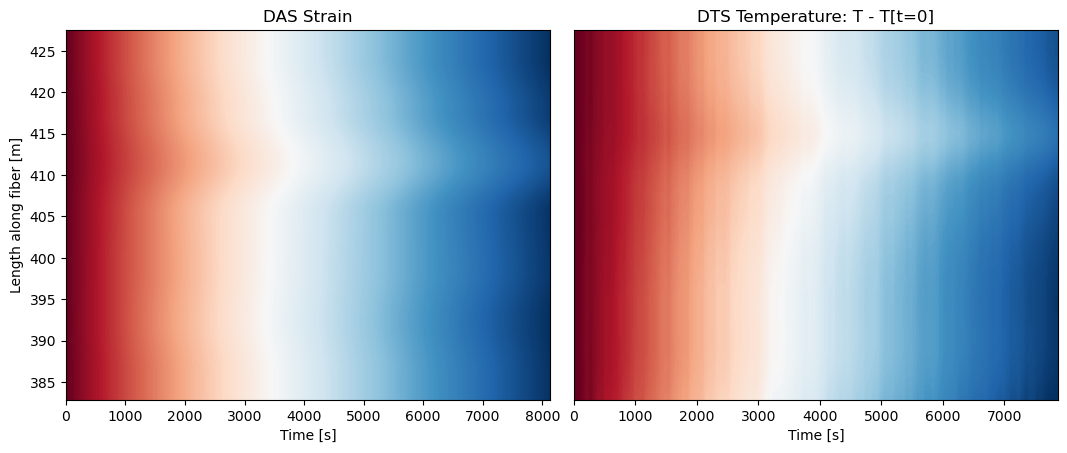

In [809]:
# plot the selected DAS and DTS data
fig, ax = plt.subplots(1,2, figsize=(2*6.4,4.8))

# left plot (DAS measurement)
T_0 = (temp_arr[0][::int(attrs['SpatialSamplingInterval']/(df.index[1]-df.index[0]))])[:-1]
data_select_int = data_select.copy() 
# data_select_int[0,:] = T_0

im1 = ax[0].imshow(np.cumsum(data_select_int, axis=0).T, origin='lower',
           aspect='auto',
             # vmin=np.percentile(data_norm[~np.isnan(data_norm)],1),
             # vmax=np.percentile(data_norm[~np.isnan(data_norm)],99),
           extent=[0, (all_times[-1]-all_times[0]).total_seconds(),
                   start_cha*attrs['SpatialSamplingInterval'],
                   end_cha*attrs['SpatialSamplingInterval']],
            cmap='RdBu_r',
            )
# right plot (DTS measurement)
temp_filt = temp_arr.copy()
[b,a]=scipy.signal.butter(2, 1/attrs['GaugeLength']/2.,'lowpass', fs=1/(df.index[1]-df.index[0])) # frequency in m
temp_filt = scipy.signal.filtfilt(b,a,temp_filt,axis=1)
im2 = ax[1].imshow((temp_filt-temp_filt[0,:]).T, origin='lower',
           aspect='auto',
            extent=[0,(df.columns[-1]-df.columns[0]).total_seconds(),
                   df.index[0], df.index[-1]],
            cmap='RdBu_r',
            )
ax[0].set_title('DAS Strain')
ax[1].set_title('DTS Temperature: T - T[t=0]')
ax[0].set_ylabel('Length along fiber [m]')
ax[1].set_yticks([])
ax[0].set_xlabel('Time [s]')
ax[1].set_xlabel('Time [s]')

plt.subplots_adjust(wspace=0.05)
plt.show()
fig.savefig('../../plots/DAS_labtest/temperature_test/fig2_temp.png', dpi=300, bbox_inches='tight')

Text(0.5, 0, 'Time [s]')

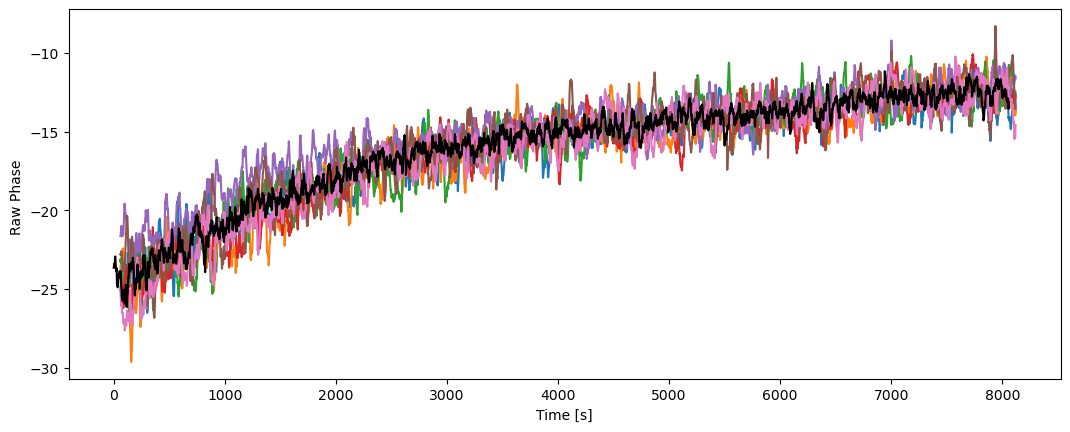

In [810]:
fig, ax = plt.subplots(figsize=(2*6.4,4.8))
t_axis = np.arange(t_start, t_end, 1/attrs['PulseRate'])
# colors = plt.cm.cividis(np.linspace(0,1,np.shape(data_select)[1]))
for i in range(np.shape(data_select)[1]):
    # ax.plot(t_axis, np.cumsum(data_select[:,i]))#, color=colors[i])
    ax.plot(t_axis, data_select[:,i])#, color=colors[i])
ax.plot(np.median(data_select, axis=1), color='k')
ax.set_ylabel('Raw Phase ')
ax.set_xlabel('Time [s]')

Text(0, 0.5, 'Temperature Difference')

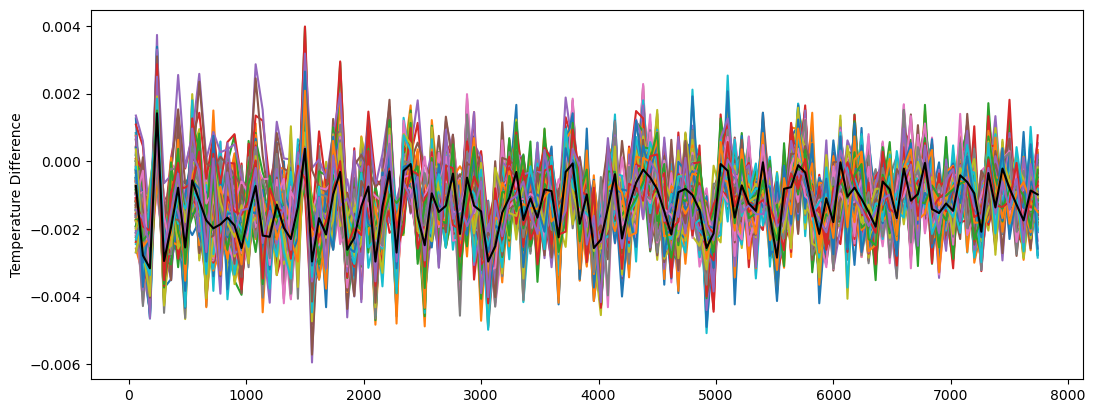

In [811]:
fig, ax = plt.subplots(figsize=(2*6.4,4.8))
t_axis = np.arange(0, np.shape(temp_arr)[0]*60, 60)
# colors = plt.cm.cividis(np.linspace(0,1,np.shape(data_select)[1]))
for i in range(np.shape(temp_arr)[1]):
    ax.plot(t_axis[1:], np.diff(temp_arr[:,i]-temp_arr[0,i])/60)#, color=colors[i])
ax.plot(t_axis[1:], np.diff(np.median(temp_arr, axis=1)-np.median(temp_arr, axis=1)[0])/60, color='k')
ax.set_ylabel('Temperature Difference')
# ax.set_xlabel('Time [s]')

Thermal expansion of glass: 8.5e-6/K
Onyx: 1 rad is equivalent to 107nm extenion over the gauge length.

In [770]:
GL = attrs['GaugeLength'] # gauge length
alpha = 8.5e-6 # K^-1 thermal expansion of glass
gamma = 107e-9 # nm/rad over the gauge length

Observed DTS cooling rate is ~0.002 to 0.006 K/s at the beginning. \
This means that we should measure a spatial differential of optical phase (that's what we measure) of: 

In [771]:
# include change of refraction index 1e-6/K

In [772]:
dTdt = 0.006 # K/s
dTdt * alpha / gamma * GL

4.562082888461701

Text(0, 0.5, 'DAS Raw Phase')

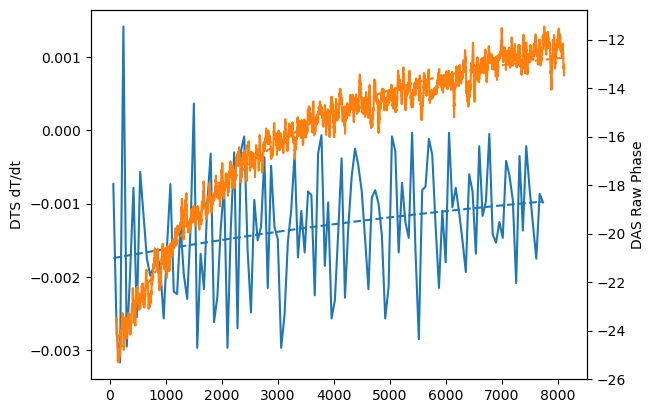

In [838]:
# fit exponential function to get better values.
from scipy.optimize import curve_fit

# fit difference in DTS data
x = np.arange(0, np.shape(temp_arr)[0]*60, 60)[1:]
y = np.diff(np.median(temp_arr, axis=1)-np.median(temp_arr, axis=1)[0])/60
popt, pcov = curve_fit(lambda t, a, b, c: a * np.exp(b * t) + c, x, y,
                      p0=(-0.001, -0.001, -0.001))
a_dts = popt[0]
b_dts = popt[1]
c_dts = popt[2]

fig,ax1 = plt.subplots()
ax1.plot(x,y, color='C0', label='DTS differentiated')
ax1.plot(x,a_dts*np.exp(b_dts*x)+c_dts, color='C0', linestyle='dashed')
ax1.set_ylabel(r'DTS dT/dt')

# fit raw DAS data
x = np.arange(t_start, t_end, 1/attrs['PulseRate'])[60:]
y = np.mean(data_select, axis=1)[60:]
popt, pcov = curve_fit(lambda t, a, b, c: a * np.exp(b * t) + c, x, y,
                      p0=(-25, -0.0001, 0.))

a_das = popt[0]
b_das = popt[1]
c_das = popt[2]

ax2 = ax1.twinx()
ax2.plot(x,y, color='C1', label='DAS')
ax2.plot(x,a_das*np.exp(b_das*x)+c_das, color='C1', linestyle='dashed')
ax2.set_ylabel('DAS Raw Phase')


Text(0, 0.5, 'DAS Raw Phase integrated')

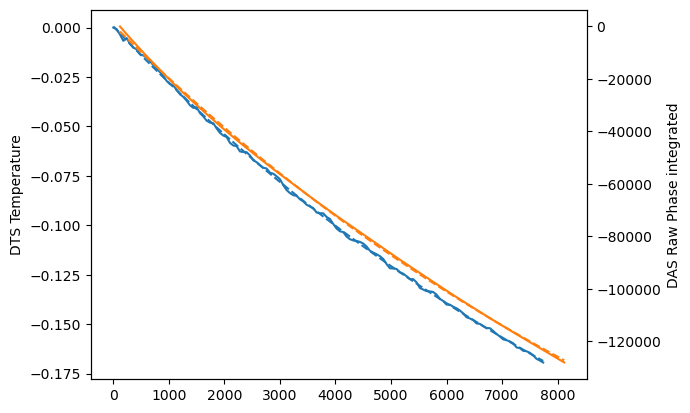

In [868]:
# probably its better to do this with the integrated data
from scipy.optimize import curve_fit

# fit difference in DTS data
x = np.arange(0, np.shape(temp_arr)[0]*60, 60)
y = (np.median(temp_arr, axis=1)-np.median(temp_arr, axis=1)[0])/60
popt, pcov = curve_fit(lambda t, a, b, c: a * np.exp(b * t) + c, x, y,
                      p0=(0.1, -0.0001, -0.1))
a_dts = popt[0]
b_dts = popt[1]
c_dts = popt[2]

fig,ax1 = plt.subplots()
ax1.plot(x,y, color='C0', label='DTS differentiated')
ax1.plot(x,a_dts*np.exp(b_dts*x)+c_dts, color='C0', linestyle='dashed')
ax1.set_ylabel(r'DTS Temperature')

# fit raw DAS data
x = np.arange(t_start, t_end, 1/attrs['PulseRate'])[60:]
y = np.cumsum(np.mean(data_select, axis=1)[60:])
popt, pcov = curve_fit(lambda t, a, b, c: a * np.exp(b * t) + c, x, y,
                      p0=(1.e5, -0.0001, 1.e5))

a_das = popt[0]
b_das = popt[1]
c_das = popt[2]

ax2 = ax1.twinx()
ax2.plot(x,y, color='C1', label='DAS')
ax2.plot(x,a_das*np.exp(b_das*x)+c_das, color='C1', linestyle='dashed')
ax2.set_ylabel('DAS Raw Phase integrated')


In [869]:
a_dts,b_dts,c_dts

(0.357151728072558, -8.292858513466799e-05, -0.3565719520256851)

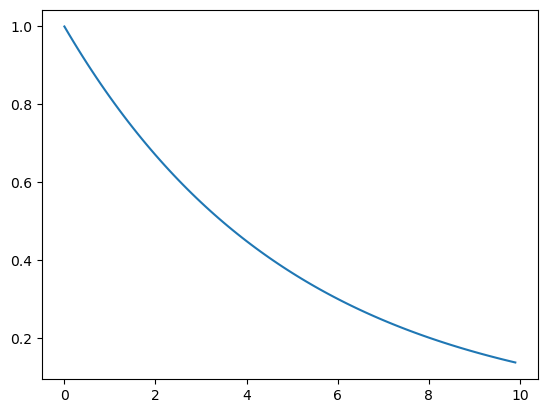

In [876]:
x = np.arange(0,10,0.1)
plt.plot(x, np.exp(-0.2*x))

In [ ]:
# finally do a fit for every single channel